# Simple language model based on feed-forward neural networks

<a target="_blank" href="https://colab.research.google.com/github/jaspock/me/blob/main/docs/materials/transformers/assets/notebooks/ffnn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a href="http://dlsi.ua.es/~japerez/"><img src="https://img.shields.io/badge/Universitat-d'Alacant-5b7c99" style="margin-left:10px"></a>

Notebook and code written by Juan Antonio Pérez in 2024. Originally inspired by the Tae Hwan Jung's code (@graykode) at the [NLP tutorial](https://github.com/graykode/nlp-tutorial).

This notebook presents an intentionally simple language model based on feed-forward neural networks. It is so oversimplified that it will be trained with sentences of exactly three words and will only be able to predict the last word of a sentence given all the previous words. Moreover, our training set will be so small that the model will probably memorize it. This implies that the network will not be able to generalize to sentences that it has not seen during training, and, as a result of that, we will test it with the same sentences used for training; this constitutes a very bad practice, that we will only use here for the sake of simplicity. In spite of all these limitations, this notebook will be useful to illustrate the basic concepts of language modeling with simple neural networks and correctly implement the architecture presented in the book by Jurafsky and Martin.

It is assumed that you are already familiar with the basics of PyTorch, but at a absolute beginner level only. This notebook complements a [learning guide](https://dlsi.ua.es/~japerez/materials/transformers/intro/) based on studying the math behind the models by reading the book "[Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/)" (3rd edition) by Jurafsky and Martin. It is part of a series of notebooks which are supposed to be incrementally studied, so make sure you follow the right order. If your learning is being supervised by a teacher, follow the additional instructions that you may have received. Although you may use a GPU environment to execute the code, the computational requirements for the default settings are so low that you can probably run it on CPU.

In [4]:
%%capture
%pip install torch matplotlib

In [5]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    
set_seed(42)  # to ensure reproducibility

## Training data and vocabulary

The following code defines the training data and the vocabulary. The global variable `window_size` defines the number of words that will be used to predict the next word. You probably understand every line of code at this point, as all is quite similar to what we have seen in previous notebooks. The function `make_batch` generates a batch of data containing the whole training set. Remember that mini-batches usually contain a subset of the training set, but we oversimplify things here and use the whole training set as a single batch. The function returns input and target data as lists of integers, each integer representing a word index in the vocabulary. These lists are obtained by iterating over the training set and extracting subsequences of `window_size` words as input and the next word as target. When converted to tensor later, the input will be of shape `(batch_size, window_size)` and the target of shape `(batch_size, 1)`.

In [19]:
window_size = 2 

sentences = ["let's promote peace", "let's ban war", "let's teach compassion", "let's build a better world"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_index = {w: i for i, w in enumerate(word_list)}
index_word = {i: w for i, w in enumerate(word_list)}
vocab_size = len(word_index)

print(f"word_index = {index_word}")

def make_batch():
    input_batch = []
    target_batch = []

    for sentence in sentences:
        words = sentence.split()  # space tokenizer
        for i in range(len(words) - 2):
            input = [word_index[words[i]], word_index[words[i+1]]]  # indices of two consecutive words
            target = word_index[words[i+2]]  # index of the next word
            input_batch.append(input)
            target_batch.append(target)

    return input_batch, target_batch

inputs, targets = make_batch()
print(f"inputs = {inputs}")
print(f"targets = {targets}")
print(f"inputs = {[[index_word[i] for i in x] for x in inputs]}")
print(f"targets = {[index_word[i] for i in targets]}")

word_index = {0: 'ban', 1: 'compassion', 2: 'war', 3: 'better', 4: 'peace', 5: 'promote', 6: 'a', 7: "let's", 8: 'world', 9: 'teach', 10: 'build'}
inputs = [[7, 5], [7, 0], [7, 9], [7, 10], [10, 6], [6, 3]]
targets = [4, 2, 1, 6, 3, 8]
inputs = [["let's", 'promote'], ["let's", 'ban'], ["let's", 'teach'], ["let's", 'build'], ['build', 'a'], ['a', 'better']]
targets = ['peace', 'war', 'compassion', 'a', 'better', 'world']


## Model definition

Our model parameters are based on already known PyTorch classes. The embedding layer is a `torch.nn.Embedding` object, and the transition from the input to the hidden layer is performed through a `torch.nn.Linear` object (inside, a weight matrix and a bias vector). The activation function at the hidden layer is computed at the `forward` function using the `nn.functional.relu` function. Note that as the ReLU function does not have learnable parameters, we do not need to declare an object of the `torch.nn.ReLU` class in the constructor. Finally, the transition from the hidden to the output layer could be performed through another `torch.nn.Linear` object. Note that the book does not use a bias vector at the output layer (the model would behave similarly with or without it, anyway), so we would set the `bias` parameter to `False` when creating this second `torch.nn.Linear` object. 

Although, we could have defined this second object of class `torch.nn.Linear` in the constructor, we have adopted a different approach here just to show how you can easily add learnable parameters of any type to your model. Objects of class `torch.nn.Parameter` represent tensors with learnable weights. `torch.nn.Parameter` represents a tensor with learnable parameters. Unlike a regular tensor that you could create in the constructor, it will be automatically added to the list of parameters of the model and will be returned when calling the function `torch.model.parameters`.  We initialize this as a random tensor of size `(hidden_size, vocab_size)` representing the matrix $\mathbf{U}$ in the book.

As already seen, the first dimension in all the operations in the `forward` function corresponds to the different items in the batch. Remember that the input to the network is a batch of lists of indices, so the first dimension of the input tensor will be the batch size. The second dimension of the input tensor is `window_size`, as we are feeding the network with the indices of `window_size` words. The embedding layer will return a tensor of size `(batch_size, window_size, embedding_size)`, where `embedding_size` is the size of each of the embedding vectors. The `torch.Tensor.view` function allows us to reshape the input tensor to `(batch_size, window_size * embedding_size)`, which is the expected size for the input layer. This concatenates the embedding vectors of the input words. The `-1`  in the first argument means that the size of the first dimension is inferred from the size of the arguments so that the total number of elements remains the same. In our case, it is an elegant way to avoid hardcoding the batch size or even using `X.shape[0]` to get it. The hidden layer will then return a tensor of size `(batch_size, hidden_size)`, and the output layer will return a tensor of size `(batch_size, vocab_size)`.

Finally, observe that the `forward` function returns the so called *logits*, that is, the output of the model before applying normalization through the softmax function. This is a common practice in PyTorch, as it allows to apply the softmax function only when needed. For example, if we are interested in the most likely word in the prediction, we may simply apply the `torch.argmax` function to the output of the model and avoid the computation of the softmax. In addition to this, the fact that the unnormalized logits are returned conditions the loss function that we will use to train the model. The `torch.nn.CrossEntropyLoss` loss function that we will use later assumes these unnormalized logits as input.

The multiplication of one-hot vectors by the embedding matrix discussed in the Jurafsky and Martin's book is not necessary, as we have a straightforward way to obtain the embedding of a word from an index by using `torch.nn.Embedding`.

📘 *Documentation:* [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), [torch.nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.Parameter.html), [torch.nn.functional.relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html), [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html), [torch.Tensor.argmax](https://pytorch.org/docs/stable/generated/torch.Tensor.argmax.html), [torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html), [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NNLM(nn.Module):
    def __init__(self, vocab_size, embedding_size, window_size, hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.window_size = window_size
        self.C = nn.Embedding(vocab_size, embedding_size)
        self.W = nn.Linear(window_size * embedding_size, hidden_size, bias=True)
        self.U = nn.Parameter(torch.randn(hidden_size, vocab_size))

    def forward(self, X):
        X = self.C(X) 
        X = X.view(-1, self.window_size * self.embedding_size)
        X = F.relu(self.W(X))
        X = torch.matmul(X, self.U) 
        return X  # return logits

## Model training

The main novelty here is the use of the `torch.optim.lr_scheduler.LinearLR` class to implement a linear learning rate decay. The `torch.optim.lr_scheduler` module provides several classes to implement different learning rate evolution strategies. The `LinearLR` class implements a linear decay from an initial learning rate to a final learning rate. The initial learning rate is set to `lr` in the constructor, and the final learning rate is set to `lr * end_factor`. The `end_factor` parameter is set to 0.5 in the code above, so the final learning rate will be half the initial learning rate. The `total_iters` parameter is used to compute the learning rate at each step. The learning rate at step `i` is computed as `lr * (1 - i / total_iters)`. The `get_last_lr` function returns the learning rate at the last step. The `torch.optim.lr_scheduler.step` function is called at each training step to update the learning rate, just after the optimizer step. We use the learning rate scheduler in combination with the Adam optimizer, but you can use it with any optimizer.

📘 *Documentation:* [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), [torch.optim.lr_scheduler.LinearLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html), [torch.optim.lr_scheduler.get_last_lr](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.get_last_lr.html), [torch.optim.lr_scheduler.step](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.step.html)

In [24]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

hidden_size = 4 
embedding_size = 2
training_steps = 1000
eval_steps = 100
lr = 0.005

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NNLM(vocab_size, embedding_size, window_size, hidden_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=training_steps)

input_batch, target_batch = make_batch()
input_batch = torch.LongTensor(input_batch)
target_batch = torch.LongTensor(target_batch)

lr_history = []  # learning rate history
model.train()
for i in range(training_steps):
    optimizer.zero_grad()
    output = model(input_batch)
    loss = criterion(output, target_batch)
    if i % eval_steps == 0:
        print(f'Step [{i}/{training_steps}], loss: {loss.item():.4f}')
    lr_history.append(scheduler.get_last_lr()[0])

    loss.backward()
    optimizer.step()
    scheduler.step()  # scheduler must be called after optimizer

print(f'Step [{training_steps}/{training_steps}], loss: {loss.item():.4f}')

Step [0/1000], loss: 2.5025
Step [100/1000], loss: 1.7750
Step [200/1000], loss: 1.0886
Step [300/1000], loss: 0.8226
Step [400/1000], loss: 0.4220
Step [500/1000], loss: 0.4096
Step [600/1000], loss: 0.4056
Step [700/1000], loss: 0.4037
Step [800/1000], loss: 0.4026
Step [900/1000], loss: 0.4021
Step [1000/1000], loss: 0.4016


## Plotting the evolution of the base learning rate

Our learning rate scheduler is quite simple, but we plot it anyway to see that it evolves as expected during training.

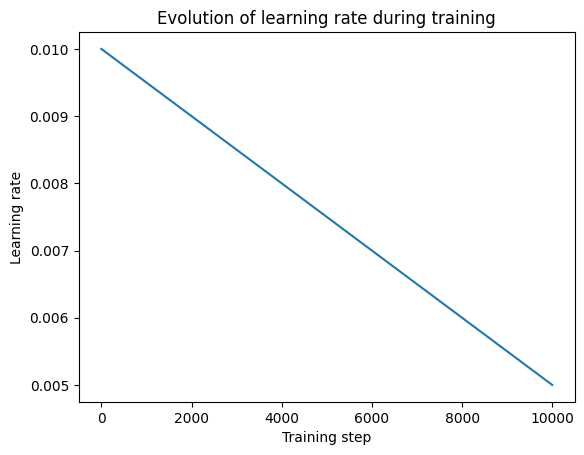

In [32]:
import matplotlib.pyplot as plt
plt.plot(lr_history)
plt.title("Evolution of learning rate during training")
plt.xlabel("Training step")
plt.ylabel("Learning rate")
plt.show()

## Model evaluation

We evaluate the model with its own training data, which is a terrible practice, but the only one that makes some sense giving the extremely small size of the training set that will not allow the model to generalize to unseen data or develop emergent behaviors. 

📘 *Documentation:*  [torch.Tensor.argmax](https://pytorch.org/docs/stable/generated/torch.Tensor.argmax.html), [torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

In [28]:
model.eval()
with torch.no_grad():
    predict = model(input_batch).argmax(dim=1)
    # iterate through input_batch and print the words corresponding to the indices in every row, then print the corresponding row in predict:
    for i in range(len(input_batch)):
        print([index_word[n.item()] for n in input_batch[i]], '⟶', index_word[predict[i].item()])

["let's", 'promote'] ⟶ peace
["let's", 'ban'] ⟶ war
["let's", 'teach'] ⟶ compassion
["let's", 'build'] ⟶ ban
['build', 'a'] ⟶ better
['a', 'better'] ⟶ world


## Exercises

If your learning path is supervised by a teacher, they may have provided you with additional instructions on how to proceed with the exercises.

✎ Replace the scheduler with one that uses the `LambdaLR` scheduler of PyTorch. Implement a lambda function that increases the learning rate for the initial `warmup_steps`, then decreases it inversely proportional to the square root of the step count. This a common learning rate scheduler used in transformer models.

✎ Comment out the scheduler and train the model without it. Perform a number of training runs with different random seeds and compare the results.